# Evaluate private factorization on movie recommendations.

We compare different approaches to learn recommender systems for real hospital data. <br/><br/>

This notebook is organized as follows: <br/><br/>

   1. Learn a recommender system assuming centralized public data. <br/><br/>
   2. Learn local models for each entity <br/><br/>
   3. Learn from private prototypes. Here we follow the same procedure as private factorization in exp2



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time
import random
import os
from utilsMovie import give_percentiles_all_m, avg_rank, process_data, train_eval, \
         give_percentiles_m, process_idx_users_items
from private_kmeans import clustering, eval_pred_movies
import pickle

import warnings
warnings.filterwarnings('ignore')

from scipy.sparse import csr_matrix
from sklearn.decomposition import NMF

rand_seed = 7
random.seed(rand_seed)
np.random.seed(rand_seed)

In [2]:
if not os.path.exists('exp4/figures/'):
    os.makedirs('exp4/figures/')


In [3]:
data_all = pd.read_csv('/Users/monic/Box/Datasets_Federated_Learning/ml-1m/ratings.dat', header=None, names = ['uid','iid', 'count','Timestamp'], sep = '::')
users = pd.read_csv('/Users/monic/Box/Datasets_Federated_Learning/ml-1m/users.dat', header=None, names = ['uid','gender','age','occ','zip'], sep = '::', index_col= 0)


In [4]:
# assign zone to user according to zip

data_all['entityid'] = users.loc[data_all.uid].zip.str.slice(stop=1).values.astype(np.int)

In [5]:
data_all.uid = data_all.uid-1
data_all = process_idx_users_items(data_all, users=False)

users = data_all.uid.unique()


In [6]:
H = len(data_all.entityid.unique())

In [7]:
u_train = np.random.binomial(1, p=0.9, size=len(users)).astype(bool)
data_all['user_train'] = u_train[data_all.uid]
data_all['rating_test'] = np.zeros_like(data_all.uid).astype(bool)
for u in users:
    if ~u_train[u]:
        tot = data_all.rating_test[data_all.uid==u].shape[0]
        data_all.rating_test[data_all.uid==u] = np.random.binomial(1, p=0.2, size=tot).astype(bool)


In [8]:
# Factorization parameters
L = [ 10, 20,30,40,50]
reg = 0.1


# k-means parameters
ks = [10,20,30,40,50]
# Privacy parameters
epsilon = 0.1
delta = 0.1


# hospitals
list_hosp_all = [i for i in range(H)]        #  all hospitals


# 1. Centralized (traditional - standard) NMF

In [12]:
RESULTS_full = {}
it = data_all.iid.unique().shape[0]
for n_c in L:
        RESULTS_full[n_c] = train_eval(data_all, n_c,reg, total_items=it)
        pickle.dump(RESULTS_full, open("exp4/results_full1M.p", "wb"))  # save it into a file named save.p




 Finished factorizing

 Finished factorizing

 Total number of test users: 597

 RMSE:  0.054956406567358757  --  RMSE train: 2.618711704091595  --  RMSE test: 2.790214569896945  

 Finished factorizing

 Finished factorizing

 Total number of test users: 597

 RMSE:  0.054074031119331574  --  RMSE train: 2.5019261216824105  --  RMSE test: 2.7111566683320234  

 Finished factorizing

 Finished factorizing

 Total number of test users: 597

 RMSE:  0.053571349561211706  --  RMSE train: 2.4390814108518244  --  RMSE test: 2.6788058909283787  

 Finished factorizing

 Finished factorizing

 Total number of test users: 597

 RMSE:  0.05319894647680399  --  RMSE train: 2.399320335752263  --  RMSE test: 2.6738834520289103  

 Finished factorizing

 Finished factorizing

 Total number of test users: 597

 RMSE:  0.05286789356616863  --  RMSE train: 2.3649570618264786  --  RMSE test: 2.680051658249082  


# 2. Local models - each hospital factorizes its own data

In [15]:

RESULTS_local = {}
for n_c in L:
        for hosp_id in list_hosp_all:
            data = data_all[data_all.entityid==hosp_id].copy()
            data = process_idx_users_items(data)
            it = data.iid.unique().shape[0]
            pat = data.uid.unique().shape[0]
            if it<n_c or pat<n_c:
                   res = {'rmse_train_all': np.nan, \
                        'rmse_train': np.nan,\
                        'rmse_test': np.nan, \
                        'avg_rank': np.nan
                        }
            else:
                res = train_eval(data, n_c,reg, total_items =it)
            RESULTS_local[(n_c, hosp_id)] = res
            pickle.dump(RESULTS_local, open("exp4/results_local.p", "wb"))  # save it into a file named save.p



 Finished factorizing

 Finished factorizing

 Total number of test users: 71

 RMSE:  0.09737474100685317  --  RMSE train: 2.645828161674501  --  RMSE test: 2.7943876206228953  

 Finished factorizing

 Finished factorizing

 Total number of test users: 69

 RMSE:  0.09629841018320325  --  RMSE train: 2.60156294917709  --  RMSE test: 2.87117538254557  

 Finished factorizing

 Finished factorizing

 Total number of test users: 26

 RMSE:  0.10297176916055502  --  RMSE train: 2.51681808362932  --  RMSE test: 3.0388045376725636  

 Finished factorizing

 Finished factorizing

 Total number of test users: 40

 RMSE:  0.10818065580500114  --  RMSE train: 2.5292310148890853  --  RMSE test: 2.6307689625657233  

 Finished factorizing

 Finished factorizing

 Total number of test users: 49

 RMSE:  0.0976182349169912  --  RMSE train: 2.580739721250704  --  RMSE test: 2.8180512074203956  

 Finished factorizing

 Finished factorizing

 Total number of test users: 79

 RMSE:  0.09804754344332


 Finished factorizing

 Finished factorizing

 Total number of test users: 47

 RMSE:  0.09281823924546549  --  RMSE train: 2.081708885473401  --  RMSE test: 3.2420620949513186  

 Finished factorizing

 Finished factorizing

 Total number of test users: 38

 RMSE:  0.09654949929958885  --  RMSE train: 2.1277244593183635  --  RMSE test: 3.209902477012321  

 Finished factorizing

 Finished factorizing

 Total number of test users: 29

 RMSE:  0.10020855086080309  --  RMSE train: 1.9749150718271402  --  RMSE test: 3.141262952302262  

 Finished factorizing

 Finished factorizing

 Total number of test users: 149

 RMSE:  0.07401473021365279  --  RMSE train: 2.3162937698262827  --  RMSE test: 2.8197011246475823  


# 3. Federated model

### (a) generate means

In [10]:
losses_pr = {}
centers_pr = {}

RANGE = 4



it = data_all.iid.unique().shape[0]

for k in ks:
    for h in list_hosp_all:
        data = data_all[data_all.entityid==h].copy()
        data = process_idx_users_items(data, users=True, items=False)
        X = csr_matrix((data['count'][~data.rating_test], (data.uid[~data.rating_test], data.iid[~data.rating_test])), shape=(data.uid.unique().shape[0], it)).toarray()
        RANGE = 4
        SIDE_LENGTH = np.amax(np.abs(X))
        print(k)
        res = clustering( X.T, k=k ,epsilon=epsilon,delta=delta,RANGE= RANGE, side_length=SIDE_LENGTH , JLcoef = 0.5, T=1)
        losses_pr[(k, h)] = res[4]
        centers_pr[(k, h)]=res[0]
        pickle.dump(losses_pr,  open('exp4/losses_privatekmeans.p', 'wb'))
        pickle.dump(centers_pr, open('exp4/centers_privatekmeans.p', 'wb'))



10
 sparsity:  1260
 DATA SHAPE: (3706, 662)
Range : 124.46476191292714 

 Round: 1   of  1 

   Projecting in dim 3
 PROJECTED  SHAPE: (3, 662)
range projected:  132.14079096980535, side_length proj 129.6642913725399
     2375   -  trials for candidate sets
     0-th trial for candidate set

     500-th trial for candidate set

     1000-th trial for candidate set

     1500-th trial for candidate set

     2000-th trial for candidate set

   Candidate set finished. Produced (2376, 3) candidates

2376 candidates, 10 clusters
0-th iteration for local search

500-th iteration for local search

1000-th iteration for local search

1500-th iteration for local search

2000-th iteration for local search

2500-th iteration for local search

3000-th iteration for local search

3500-th iteration for local search

4000-th iteration for local search

4500-th iteration for local search

5000-th iteration for local search

5500-th iteration for local search

6000-th iteration for local search

6500

KeyboardInterrupt: 

### (b) train recommender

In [9]:
centers_pr = pickle.load(open('exp4/centers_privatekmeans.p', 'rb'))


In [10]:
RESULTS_private = {}
it = data_all.iid.unique().shape[0]

for k in ks:
    kmeans_centers = np.concatenate([centers_pr[(k,  h)].T for h in list_hosp_all])
    kmeans_centers[kmeans_centers<0] = 0
    for n_comp in L:
        if n_comp>=kmeans_centers.shape[0]:
            break
        # Learn central model
        model_kp = NMF(n_components=n_comp, init='nndsvd', alpha=reg)
        W_kp = model_kp.fit_transform(kmeans_centers)
        H_kp = model_kp.components_
        errors = {}
        for hosp_id in list_hosp_all:
            data = data_all[data_all.entityid==hosp_id].copy()
            data = process_idx_users_items(data, users=True, items = False)
            pat = data.uid.unique().shape[0]
            X = csr_matrix((data['count'][~data.rating_test], \
                                               (data.uid[~data.rating_test], data.iid[~data.rating_test])), \
                                              shape=(pat, it)).toarray()
            model_hosp = NMF(n_components=n_comp, init='custom', random_state=0, alpha=0.1)
            W_init = model_kp.transform(X)
            W_hosp = model_hosp.fit_transform(X, H=H_kp, W = W_init)
            H_hosp = model_kp.components_
            X_hat = np.matmul(W_hosp, H_hosp)
            RESULTS_private[(k,n_comp, hosp_id)] = eval_pred_movies(data, X, X_hat)
            pickle.dump(RESULTS_private, open("exp4/results_private_fed.p", "wb"))  # save it into a file named save.p



 RMSE:  0.6139623676923494  --  RMSE train: 2.6467680037267356  --  RMSE test: 2.7982781767534823  

 RMSE:  0.6084020639426183  --  RMSE train: 2.6056880265158777  --  RMSE test: 2.8675418212414483  

 RMSE:  0.6180279276352749  --  RMSE train: 2.520096618797699  --  RMSE test: 3.0482029243055813  

 RMSE:  0.6030713147344189  --  RMSE train: 2.5316670274592705  --  RMSE test: 2.629639164054513  

 RMSE:  0.6074185145318932  --  RMSE train: 2.5859940597680886  --  RMSE test: 2.8218207632142236  

 RMSE:  0.6002223337138907  --  RMSE train: 2.629976437315375  --  RMSE test: 2.9542436884531025  

 RMSE:  0.6387014664354723  --  RMSE train: 2.4932747644590947  --  RMSE test: 2.8762994147111254  

 RMSE:  0.6215844386443864  --  RMSE train: 2.5568729330752724  --  RMSE test: 2.924543347602049  

 RMSE:  0.606902785288175  --  RMSE train: 2.4767629698618605  --  RMSE test: 2.8353304145440794  

 RMSE:  0.6297857364328199  --  RMSE train: 2.5898772814489317  --  RMSE test: 2.73042648448058


 RMSE:  0.5444118365864767  --  RMSE train: 2.2003859749770225  --  RMSE test: 3.0692743676783376  

 RMSE:  0.5204016269971807  --  RMSE train: 2.1631048350035025  --  RMSE test: 2.9195589904052053  

 RMSE:  0.543464062927367  --  RMSE train: 2.279974885016743  --  RMSE test: 3.0535810655298157  

 RMSE:  0.544259286845307  --  RMSE train: 2.349003928277584  --  RMSE test: 3.1917139537356967  

 RMSE:  0.5603872227088016  --  RMSE train: 2.157298491568077  --  RMSE test: 3.2540444720343844  

 RMSE:  0.542766681666736  --  RMSE train: 2.204682355507336  --  RMSE test: 3.094914751574926  

 RMSE:  0.5150455159475212  --  RMSE train: 2.074514971474002  --  RMSE test: 3.0909559817357253  

 RMSE:  0.5846635610669796  --  RMSE train: 2.355456709342844  --  RMSE test: 2.728256778937045  

 RMSE:  0.5409371476797531  --  RMSE train: 2.30064806412794  --  RMSE test: 2.979816830121337  

 RMSE:  0.5304932819541333  --  RMSE train: 2.2424277200587404  --  RMSE test: 2.902909732524922  

 RMS


 RMSE:  0.5805609453579267  --  RMSE train: 2.442417519312679  --  RMSE test: 2.778499957897149  

 RMSE:  0.5769968148127621  --  RMSE train: 2.502568804049737  --  RMSE test: 2.905225144728127  

 RMSE:  0.6088171495332707  --  RMSE train: 2.348059237804234  --  RMSE test: 2.9283231072822136  

 RMSE:  0.5893905417315858  --  RMSE train: 2.4107612857027063  --  RMSE test: 2.952711467346144  

 RMSE:  0.5708874843996475  --  RMSE train: 2.308681888293212  --  RMSE test: 3.008228709049005  

 RMSE:  0.6082419078065231  --  RMSE train: 2.471292954080995  --  RMSE test: 2.66441305901734  

 RMSE:  0.5723692492252351  --  RMSE train: 2.432071335530606  --  RMSE test: 2.769231600072745  

 RMSE:  0.5629263725740871  --  RMSE train: 2.3796201092539544  --  RMSE test: 2.8086498690937702  

 RMSE:  0.5650266418207859  --  RMSE train: 2.2811471834506074  --  RMSE test: 3.0038439726715915  

 RMSE:  0.5445253425247499  --  RMSE train: 2.268972793389828  --  RMSE test: 2.807607061634399  

 RMS


 RMSE:  0.5395275279121039  --  RMSE train: 2.076939600360648  --  RMSE test: 3.2705937720273126  

 RMSE:  0.5217946243910405  --  RMSE train: 2.118633572814381  --  RMSE test: 3.1146782619741713  

 RMSE:  0.49031666615866304  --  RMSE train: 1.9736200072274548  --  RMSE test: 3.305632778794478  

 RMSE:  0.575539140636981  --  RMSE train: 2.315703109784605  --  RMSE test: 2.794259732904827  


### PLOT

In [24]:
RESULTS_full = pickle.load(open('exp4/results_full1M.p', 'rb'))
RESULTS_local = pickle.load(open('exp4/results_local.p', 'rb'))
RESULTS_private = pickle.load(open('exp4/results_private_fed.p', 'rb'))

In [25]:
# Scale results by size of hospital

test_sizes = data_all.entityid[data_all.rating_test].value_counts()
all_test = sum(data_all.rating_test)


In [26]:
list_hosp_test = [h for h in list_hosp_all if ~np.isnan(RESULTS_local[(10,h)]['rmse_test'])]

In [29]:
full = [RESULTS_full[l]['rmse_test'] for l in L]
local = []
for l in L:
    list_hosp_test = [h for h in list_hosp_all if ~np.isnan(RESULTS_local[(l,h)]['rmse_test'])]
    res = sum(RESULTS_local[(l, h)]['rmse_test']*test_sizes[h]/all_test for h in list_hosp_test)
    local.append(res)
federated = {}
for k in ks:
    res  = [sum(RESULTS_private[(k,l, h)]['rmse_test']*test_sizes[h]/all_test for h in test_sizes.index) for l in L]
    federated[k] = res
        


In [30]:
colors = ['#4477AA', '#66CCEE', '#228833', '#CCBB44', '#EE6677', '#AA3377']


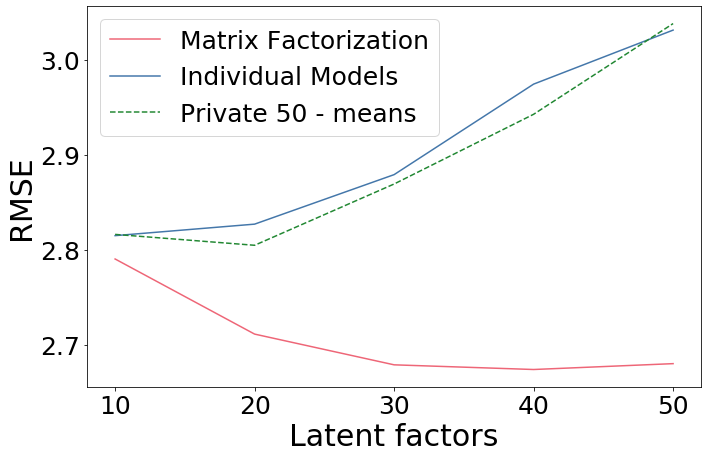

In [31]:

fig, axs = plt.subplots( figsize=(11,7))



#Plot aggregated model

k=10
axs.plot(L,full , label = 'Matrix Factorization', color = colors[4])
axs.plot(L, local , label = 'Individual Models', color = colors[0] )
axs.plot(L, federated[10] , label = 'Private 50 - means'.format(k), linestyle = '--', color = colors[2])


#General features
#axs.set_title('RMSE test for different methodologies',fontsize = 40, pad = 20)

axs.set_xlabel('Latent factors',fontsize = 30)
axs.set_ylabel('RMSE',fontsize = 30)

axs.set_xticks(L)
# axs[1].set_xticks(x)
#ax.set_xticklabels([1,4,5], fontsize=12)axs[1].set_xticklabels([10,20,30,40,50])
plt.legend(fontsize=25)
axs.xaxis.set_tick_params(labelsize=25)
axs.yaxis.set_tick_params(labelsize=25)
plt.savefig('exp4/figures/RMSE_test_newPal.pdf')
plt.show()

In [32]:
train_sizes = data_all.entityid[~data_all.rating_test].value_counts()
all_train = sum(~data_all.rating_test)

full = [RESULTS_full[l]['rmse_train'] for l in L]
local = []
for l in L:
    list_hosp_train = [h for h in list_hosp_all if ~np.isnan(RESULTS_local[(l,h)]['rmse_train'])]
    res = sum(RESULTS_local[(l, h)]['rmse_train']*train_sizes[h]/all_train for h in list_hosp_train if h in train_sizes.index)
    local.append(res)
federated = {}
for k in ks:
    res  = [sum(RESULTS_private[(k,l, h)]['rmse_train']*train_sizes[h]/all_train for h in train_sizes.index) for l in L]
    federated[k] = res
        


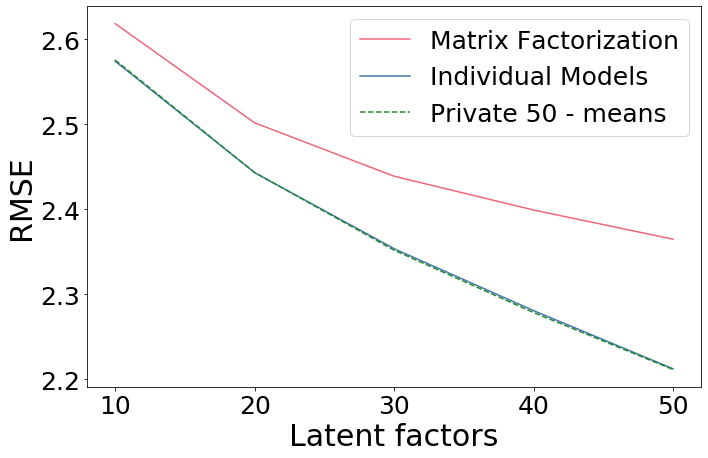

In [33]:

fig, axs = plt.subplots( figsize=(11,7))



#Plot aggregated model

k=10
axs.plot(L,full , label = 'Matrix Factorization', color = colors[4])
axs.plot(L, local , label = 'Individual Models', color = colors[0])
axs.plot(L, federated[10] , label = 'Private 50 - means'.format(k), linestyle = '--', color = colors[2])


#General features
#axs.set_title('RMSE train for different methodologies',fontsize = 40, pad = 20)

axs.set_xlabel('Latent factors',fontsize = 30)
axs.set_ylabel('RMSE',fontsize = 30)

axs.set_xticks(L)
# axs[1].set_xticks(x)
#ax.set_xticklabels([1,4,5], fontsize=12)axs[1].set_xticklabels([10,20,30,40,50])
plt.legend(fontsize=25)
axs.xaxis.set_tick_params(labelsize=25)
axs.yaxis.set_tick_params(labelsize=25)
plt.savefig('exp4/figures/RMSE_train_newPal.pdf')
plt.show()

In [34]:
test_sizes = data_all.entityid[data_all.rating_test].value_counts()
all_test = sum(data_all.rating_test)

full = [RESULTS_full[l]['avg_rank'] for l in L]
local = []
for l in L:
    list_hosp_test = [h for h in list_hosp_all if ~np.isnan(RESULTS_local[(l,h)]['avg_rank'])]
    res = sum(RESULTS_local[(l, h)]['avg_rank']*test_sizes[h]/all_test for h in list_hosp_test if h in test_sizes.index)
    local.append(res)
federated = {}
for k in ks:
    res  = [sum(RESULTS_private[(k,l, h)]['avg_rank']*test_sizes[h]/all_test for h in test_sizes.index) for l in L]
    federated[k] = res
        


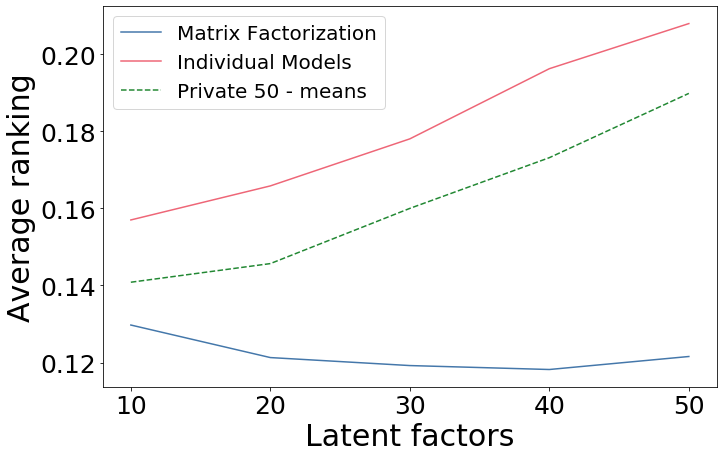

In [35]:

fig, axs = plt.subplots( figsize=(11,7))



#Plot aggregated model

k=10
axs.plot(L,full , label = 'Matrix Factorization',color = colors[0])
axs.plot(L, local , label = 'Individual Models',color = colors[4])
axs.plot(L, federated[10] , label = 'Private 50 - means'.format(k), linestyle = '--', color = colors[2])


#General features
#axs.set_title('Average ranking for different methodologies',fontsize = 40, pad = 20)

axs.set_xlabel('Latent factors',fontsize = 30)
axs.set_ylabel('Average ranking',fontsize = 30)

axs.set_xticks(L)
# axs[1].set_xticks(x)
#ax.set_xticklabels([1,4,5], fontsize=12)axs[1].set_xticklabels([10,20,30,40,50])
plt.legend(fontsize=20)
axs.xaxis.set_tick_params(labelsize=25)
axs.yaxis.set_tick_params(labelsize=25)
plt.savefig('exp4/figures/avg_rank_newPal.pdf')
plt.show()